In [123]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'
plt.rcParams["figure.dpi"] = 70

base_dir = Path().resolve().parent
data_dir = base_dir / 'data'
sys.path.append(str(base_dir))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [102]:
data = pd.read_csv(data_dir / 'featuresWithRisks.csv', index_col=0)
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

data = data.drop(columns=['Income', 'Outcome'])
target = 'Balance'
features = list(data.drop(columns=target).columns)

X, y = data[features], data[target]

## Встроенный метод

Автоматические методы, по сути отбирающие признаки во время обучения (L1, L2 регуляризации)

Добавить при выборе основной модели

Пример:

In [104]:
from sklearn.svm import SVR

# В SVM по умолчанию присутствует L2 регуляризация (за его величину отвечает параметр C)
model = SVR(C=1)
model.fit(X, y)

SVR(C=1)

## Оберточный метод - SequentialFeatureSelector

Для увеличения стабильности метода мы будем использовать кросс-валидацию во время использования этого метода, но обычная кросс-валидация нам не подойдет (так как мы работаем с временными рядами), поэтому будем использовать специальный сплит для временных рядов.

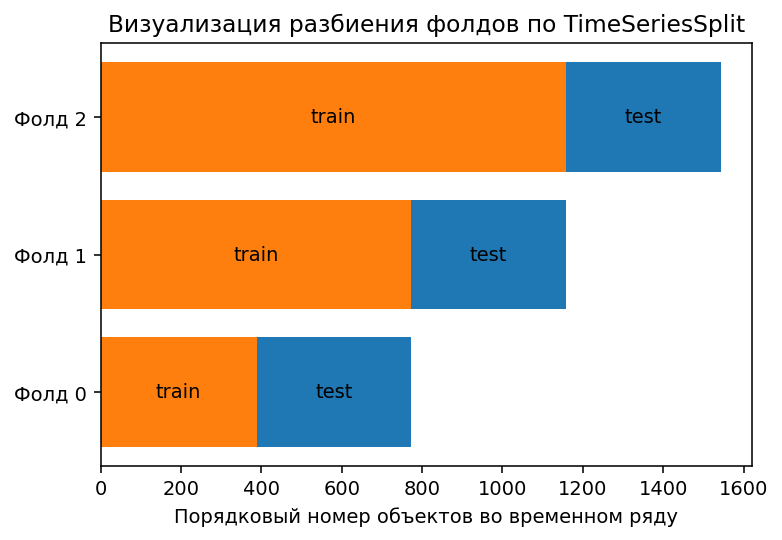

In [105]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=3)
for i, (train, test) in enumerate(tscv.split(data)):
    bar = plt.barh(f'Фолд {i}', train.shape[0], color='tab:orange')
    plt.bar_label(bar, labels=['train'], label_type='center')

    bar = plt.barh(f'Фолд {i}', test.shape[0], left=train.shape[0], color='tab:blue')
    plt.bar_label(bar, labels=['test'], label_type='center')

plt.title('Визуализация разбиения фолдов по TimeSeriesSplit')
plt.xlabel('Порядковый номер объектов во временном ряду');

In [115]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.svm import SVR

model = SVR()
n_splits = 3
sfs = SequentialFeatureSelector(model, cv=TimeSeriesSplit(n_splits), n_features_to_select=10, n_jobs=-1)
%time sfs.fit(X, y)

CPU times: user 1.73 s, sys: 493 ms, total: 2.22 s
Wall time: 37 s


SequentialFeatureSelector(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
                          estimator=SVR(), n_features_to_select=10, n_jobs=-1)

In [116]:
selected_features_mask = sfs.get_support()
selected_features = X.columns[selected_features_mask]
print('Выбранные признаки:\n')
print(*selected_features, sep='\n')

Выбранные признаки:

Взносы, уплачиваемые ИП за себя
Взносы, перечисляемые в ФСС
Налог на добычу полезных ископаемых (Последняя неделя каждого месяца)
Real Wage Growth YoY: forecastCorrection
Retail Sales YoY: actual
Markit Manufacturing PMI: forecastCorrection
BZ=F
IMOEX.ME
period_0.25
period_3.0


## Фильтрационный метод - Correlation-based Feature Selection

In [121]:
from tslib.feature_selection import get_best_cfs_features

print(get_best_cfs_features.__doc__)
selected_features, _ = get_best_cfs_features(data, features, target)
print('Выбранные признаки:\n')
print(*selected_features, sep='\n')


    Нахождение лучшего сабсета признаков на основе CFS - Correlation-based Feature Selection.
    По сути ищем признаки, сильно коррелирующие с таргетом, и слабо коррелирубщие между собой.
    Для нахождение сабсета используется жадный алгоритм, аналогичный sklearn.feature_selection.SequentialFeatureSelector с direction='forward', но без кросс-валидации
    
Выбранные признаки:

IMOEX.ME
НДС
Налог на добычу полезных ископаемых (Последняя неделя каждого месяца)
Зарплаты и авансы (не позднее 15 и 30 числа каждого месяца)
COVID cases (см вкладку)


### Сравнение методов по стабильности

Будем проверять стабильность по тому, как сильно меняются метрики при тесте на разных фолдах

In [125]:
from collections import defaultdict

from tslib.scoring import get_score
from tslib.feature_selection import fit_default_model, fit_sfs_model, fit_cfs_model

tscv = TimeSeriesSplit(n_splits=5)

metric_dict = defaultdict(list)

for train_idx, test_idx in tqdm(list(tscv.split(data))):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]

    for method in ['default', 'sfs', 'cfs']:
        fit_func = globals()[f'fit_{method}_model']
        current_model, selected_features = fit_func(model, X_train, y_train)

        pred = current_model.predict(X_test[selected_features])
        score = get_score(y_test, pred)
        metric_dict[method].append(score)

  0%|          | 0/5 [00:00<?, ?it/s]

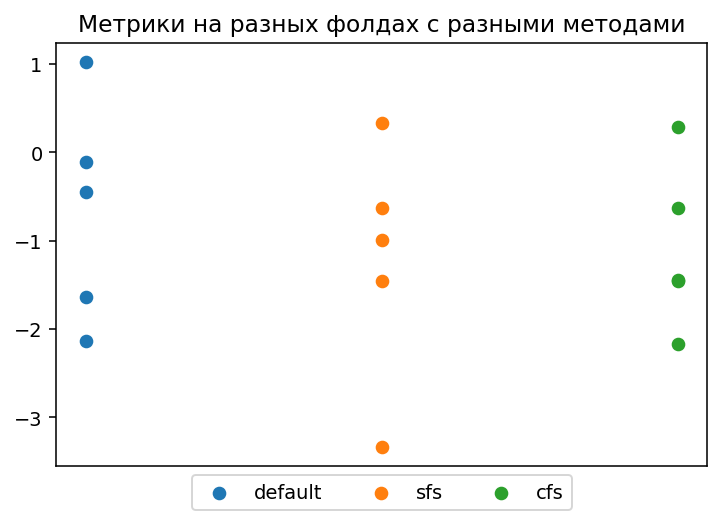

In [126]:
for i, (method, vals) in enumerate(metric_dict.items()):
    plt.scatter([i]*len(vals), vals, label=method)

plt.xticks([])
plt.legend(bbox_to_anchor=(0.5, 0), loc='upper center', ncol=3)
plt.title('Метрики на разных фолдах с разными методами');

In [127]:
fs_summary = pd.DataFrame(index=['mean', 'std'])
for method, vals in metric_dict.items():
    mean = np.mean(vals).round(2)
    std = np.std(vals).round(2)
    fs_summary[method] = [mean, std]

fs_summary

,default,sfs,cfs
mean,-0.66,-1.21,-1.08
std,1.12,1.21,0.84
